<a href="https://colab.research.google.com/github/lori930/EfficientAI/blob/main/Demo_Pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MIT 6.5940 Fall 2023: Lecture 1 Pruning Demo**


This colab notebook provides code and a framework for  thedemo used in ***Lecture 1 Pruning***.

The neural network model definition and training schedule are adapted from [PyTorch example](https://github.com/pytorch/examples/blob/main/mnist/main.py).



# Setup

First, install the required packages and download the datasets and pretrained model. Here we use CIFAR10 dataset and VGG network which is the same as what we used in the Lab 0 tutorial.

In [ ]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
All required packages have been successfully installed!


In [ ]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

import torch.nn.functional as F

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: StepLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer
    optimizer.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

  # Update scheduler
  scheduler.step()

In [ ]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

Helper Functions (Flops, Model Size calculation, etc.)

In [ ]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

Define pruning functions.

In [ ]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()
    num_zeros = round(num_elements * sparsity) # calculate ideal #zero element in tensor

    importance = tensor.abs() # make negative value becomes positive
    print('importance',importance)
    #The view(-1) method reshapes the importance tensor into a one-dimensional tensor
    # The kthvalue() method returns a tuple containing the kth smallest value in the input tensor and its index.
    #.     The num_zeros parameter specifies the value of k.

    # The values attribute of the tuple returned by kthvalue() contains the kth(#num_zeros) smallest value in the input tensor.

    threshold = importance.view(-1).kthvalue(num_zeros).values
    print('treshold',threshold)
    mask = torch.gt(importance, threshold) #if the value > treshold, then set to True
    print('mask',mask)
    tensor.mul_(mask)
    print('mul_mask',tensor.mul_(mask))
    return mask

In [ ]:
# Example
tensor = torch.tensor([[-1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]])
sparsity = 0.5 # prune 50% of the elements in the tensor
fine_grained_prune(tensor, sparsity)


importance tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])
treshold tensor(4.)
mask tensor([[False, False, False],
        [False,  True,  True],
        [ True,  True,  True]])
mul_mask tensor([[-0., 0., 0.],
        [0., 5., 6.],
        [7., 8., 9.]])


tensor([[False, False, False],
        [False,  True,  True],
        [ True,  True,  True]])

In [ ]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                if isinstance(sparsity_dict, dict):
                    masks[name] = fine_grained_prune(param, sparsity_dict[name])
                else:
                    assert(sparsity_dict < 1 and sparsity_dict >= 0)
                    if sparsity_dict > 0:
                        masks[name] = fine_grained_prune(param, sparsity_dict)
        return masks

Load the MNIST dataset.

In [ ]:
# transforms.Compose is used to chain together multiple image transformations in PyTorch.
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
to_image = lambda t: (t*0.3081+0.1307).squeeze(0).to('cpu').numpy()

dataset = {}
for split in ["train", "test"]:
  dataset[split] = MNIST(
    "data",
    train=(split == "train"),
    download=(split == "train"),
    transform=transform,
  )

dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=256 if split == 'train' else 1000,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True
  )

100%|██████████| 9912422/9912422 [00:00<00:00, 84597876.99it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 114171247.71it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 119633472.24it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6862582.41it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Create a set of test images for demo.

In [ ]:
demos = {0: 3, 1: 2, 2: 1, 3: 30, 4: 4, 5: 15, 6: 11, 7: 0, 8: 61, 9: 9}
demo_inputs, demo_images = [], []
for digit, index in demos.items():
    demo_inputs.append(copy.deepcopy(dataset['test'][index][0]))
    demo_images.append(to_image(demo_inputs[-1]))
demo_inputs = torch.stack(demo_inputs).cuda()
demo_inputs

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

# Neural Network Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) # 1 x 32 x 3 x 3 = 288 parameters
        self.conv2 = nn.Conv2d(32, 64, 3, 1) # 32 x 64 x 3 x 3=18,432 paramters
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128) # 9216 x 128 = 1,179,648 parameters
        self.fc2 = nn.Linear(128, 10) # 128 x 10 = 1,280 parameters

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Net().cuda()

# Let's Visualize the Demo Images

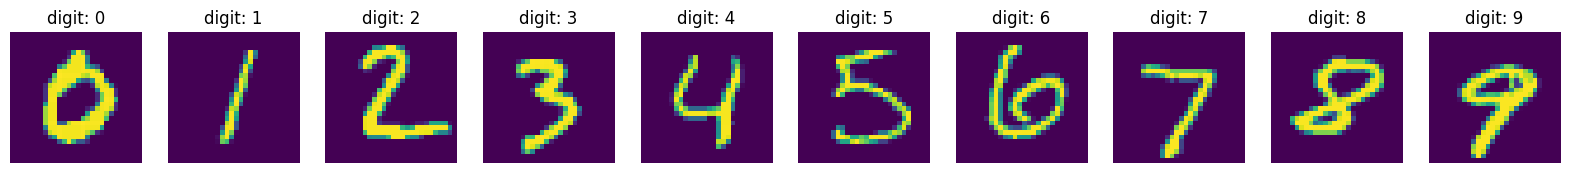

In [ ]:
def visualize(with_predictions=False):
    plt.figure(figsize=(20, 10))
    predictions = model(demo_inputs).argmax(dim=1) if with_predictions else None
    for digit, index in demos.items():
        plt.subplot(1, 10, digit + 1)
        plt.imshow(demo_images[digit])
        if predictions is None:
            plt.title(f"digit: {digit}")
        else:
            plt.title(f"digit: {digit}\npred: {int(predictions[digit])}")
        plt.axis('off')
    plt.show()

visualize()

# Pre-train Neural Network on MNIST

In [ ]:
lr = 1.0
lr_step_gamma = 0.7
num_epochs = 5

optimizer = Adadelta(model.parameters(), lr=lr)
criterion = F.nll_loss
scheduler = StepLR(optimizer, step_size=1, gamma=lr_step_gamma)

best_accuracy = 0
best_checkpoint = dict()
for epoch in range(num_epochs):
    train(model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1:>2d} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

print(f"=> loading best checkpoint")
model.load_state_dict(best_checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(best_checkpoint['state_dict'])

train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  1 Accuracy 98.08% / Best Accuracy: 98.08%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  2 Accuracy 98.62% / Best Accuracy: 98.62%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  3 Accuracy 98.87% / Best Accuracy: 98.87%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  4 Accuracy 98.83% / Best Accuracy: 98.87%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  5 Accuracy 98.97% / Best Accuracy: 98.97%
=> loading best checkpoint


# Let's First Evaluate the Accuracy and Model Size of Dense Model

Let's first evaluate the accuracy and model size of this model.

eval:   0%|          | 0/10 [00:00<?, ?it/s]

dense model has accuracy=98.97%
dense model has size=4.58 MiB


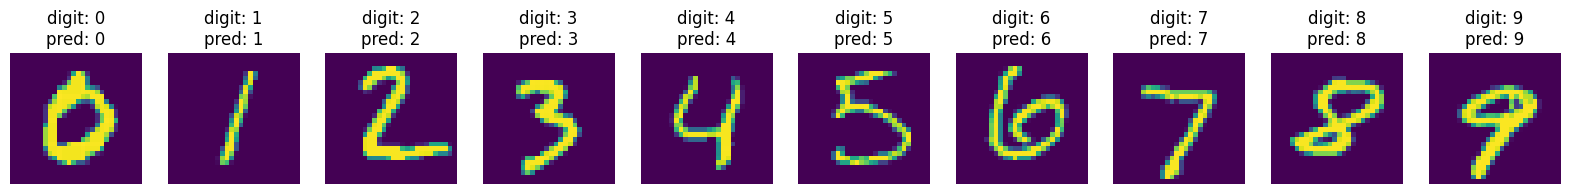

In [ ]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")
visualize(True)

# Let's Prune the Model and Re-Evaluate the Accuracy.

importance tensor([[[[0.1037, 0.0143, 0.3903],
          [0.2409, 0.1638, 0.0996],
          [0.1691, 0.3886, 0.0944]]],


        [[[0.0461, 0.1394, 0.1968],
          [0.4127, 0.2420, 0.1785],
          [0.1002, 0.2609, 0.3132]]],


        [[[0.3235, 0.1985, 0.1397],
          [0.2189, 0.0878, 0.2989],
          [0.0697, 0.0361, 0.3200]]],


        [[[0.3610, 0.2498, 0.1000],
          [0.1831, 0.2245, 0.2515],
          [0.1351, 0.2493, 0.3657]]],


        [[[0.1283, 0.3887, 0.3210],
          [0.1830, 0.0628, 0.0968],
          [0.0028, 0.4154, 0.3852]]],


        [[[0.2578, 0.1921, 0.2152],
          [0.2048, 0.0116, 0.2136],
          [0.3214, 0.0916, 0.0169]]],


        [[[0.2627, 0.2517, 0.0485],
          [0.1401, 0.2726, 0.2730],
          [0.3579, 0.2469, 0.1957]]],


        [[[0.1284, 0.2002, 0.0208],
          [0.0745, 0.0717, 0.1473],
          [0.3538, 0.3099, 0.2266]]],


        [[[0.1950, 0.3194, 0.3639],
          [0.3629, 0.0668, 0.3064],
          [0.0304, 0.

eval:   0%|          | 0/10 [00:00<?, ?it/s]

80.0% sparse model has accuracy=72.91%
80.0% sparse model has size=0.92 MiB, which is 5.00X smaller than the 4.58 MiB dense model


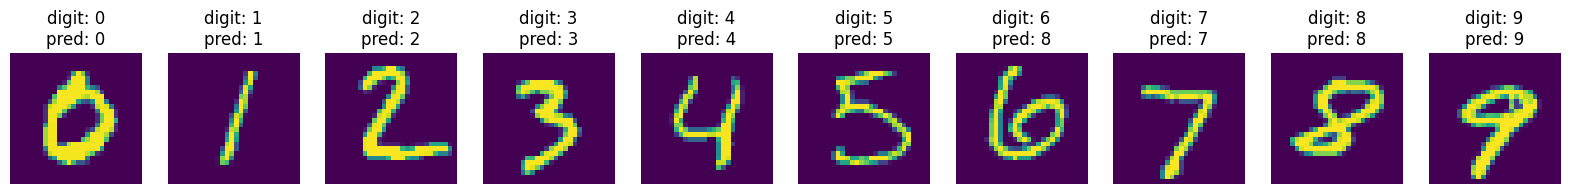

In [ ]:
sparsity = 0.8
recover_model()
pruner = FineGrainedPruner(model, sparsity)
pruner.apply(model)
sparse_model_accuracy = evaluate(model, dataloader['test'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"{sparsity*100}% sparse model has accuracy={sparse_model_accuracy:.2f}%")
print(f"{sparsity*100}% sparse model has size={sparse_model_size/MiB:.2f} MiB, "
      f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
      f"the {dense_model_size/MiB:.2f} MiB dense model")
visualize(True)

# Let's Fine-tune the Pruned Model to Get Higher Accuracy

In [ ]:
num_finetune_epochs = 2
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)

best_sparse_checkpoint = dict()
best_sparse_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_sparse_accuracy
    if is_best:
        best_sparse_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_sparse_accuracy = accuracy
    print(f'    Epoch {epoch+1} Sparse Accuracy {accuracy:.2f}% / Best Sparse Accuracy: {best_sparse_accuracy:.2f}%')

Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 1 Sparse Accuracy 98.75% / Best Sparse Accuracy: 98.75%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 2 Sparse Accuracy 98.83% / Best Sparse Accuracy: 98.83%


eval:   0%|          | 0/10 [00:00<?, ?it/s]

80.0% sparse model has accuracy=98.83%
80.0% sparse model has size=0.92 MiB, which is 5.00X smaller than the 4.58 MiB dense model


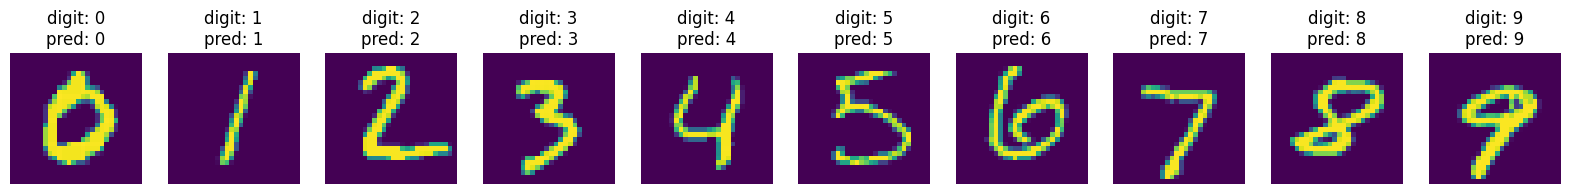

In [ ]:
model.load_state_dict(best_sparse_checkpoint['state_dict'])
sparse_model_accuracy = evaluate(model, dataloader['test'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"{sparsity*100}% sparse model has accuracy={sparse_model_accuracy:.2f}%")
print(f"{sparsity*100}% sparse model has size={sparse_model_size/MiB:.2f} MiB, "
      f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
      f"the {dense_model_size/MiB:.2f} MiB dense model")
visualize(True)